# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('D:/Projects/Module 3/m3_h1/M3_H4/bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

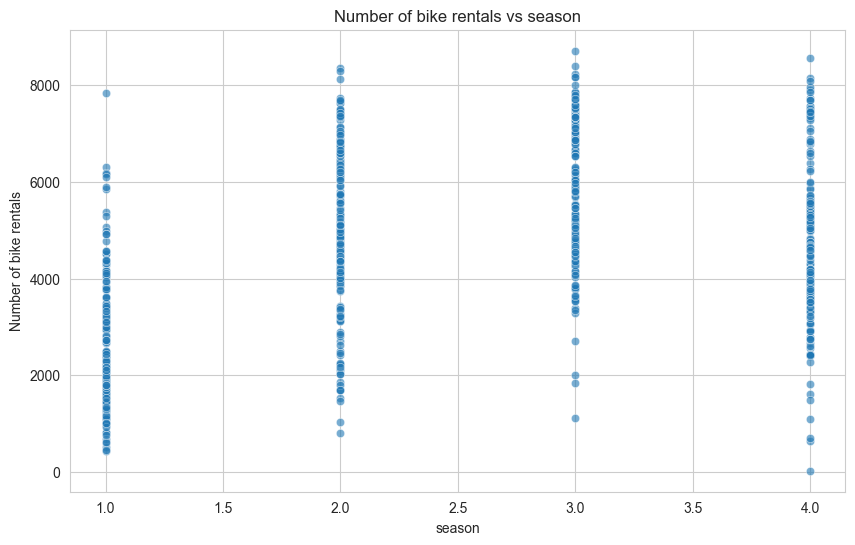

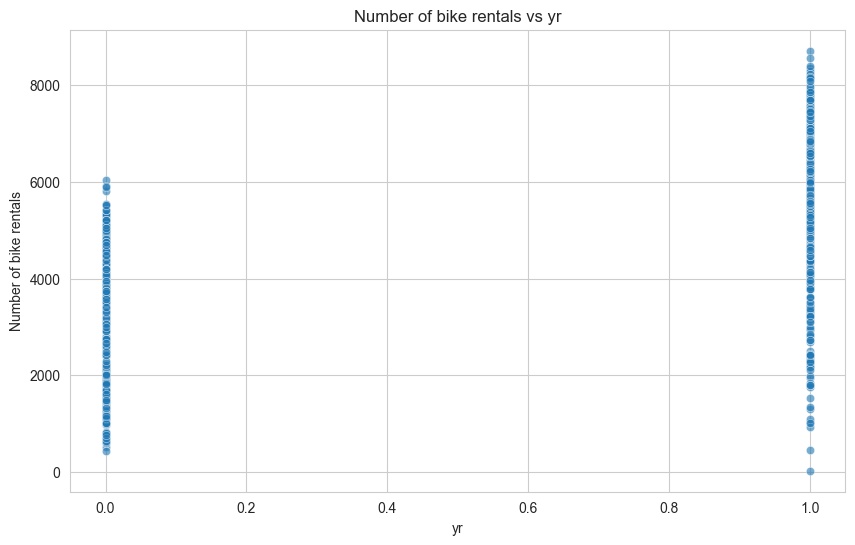

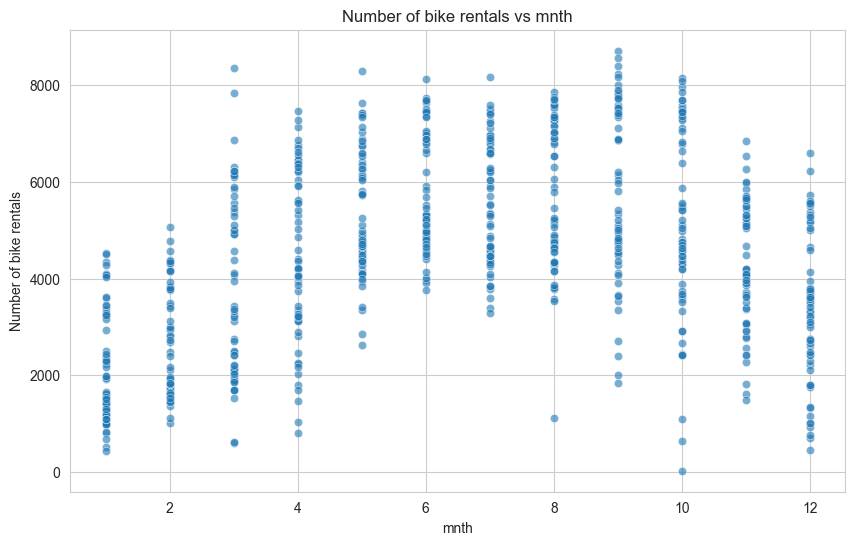

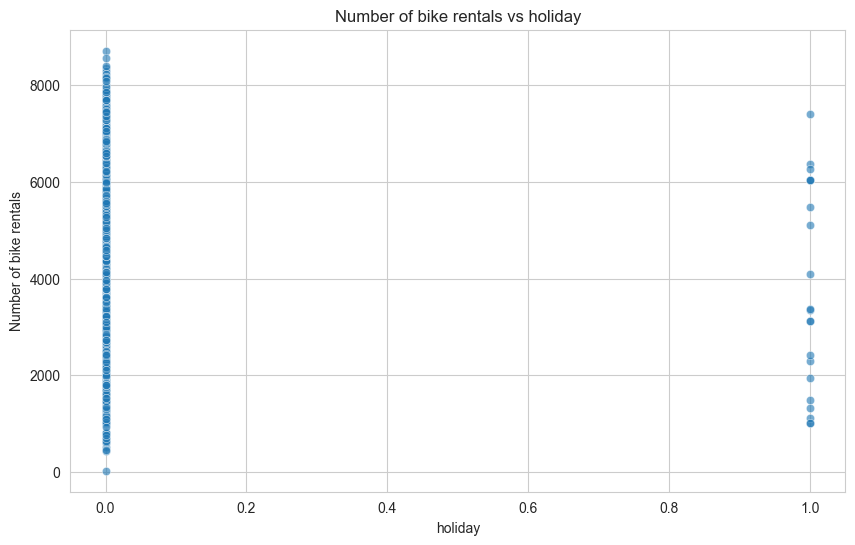

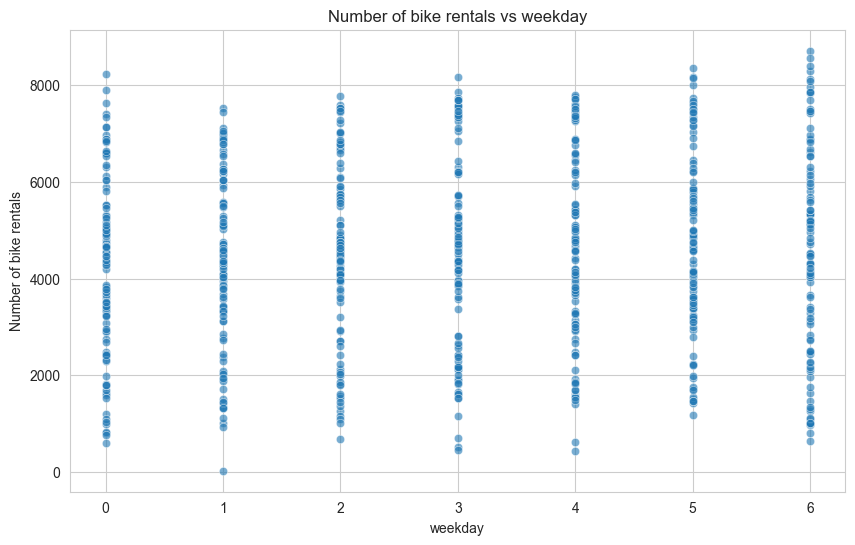

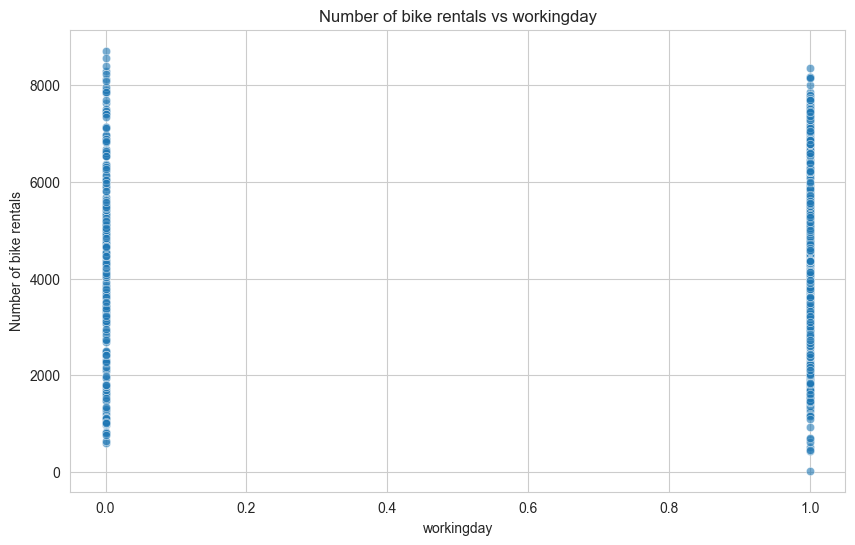

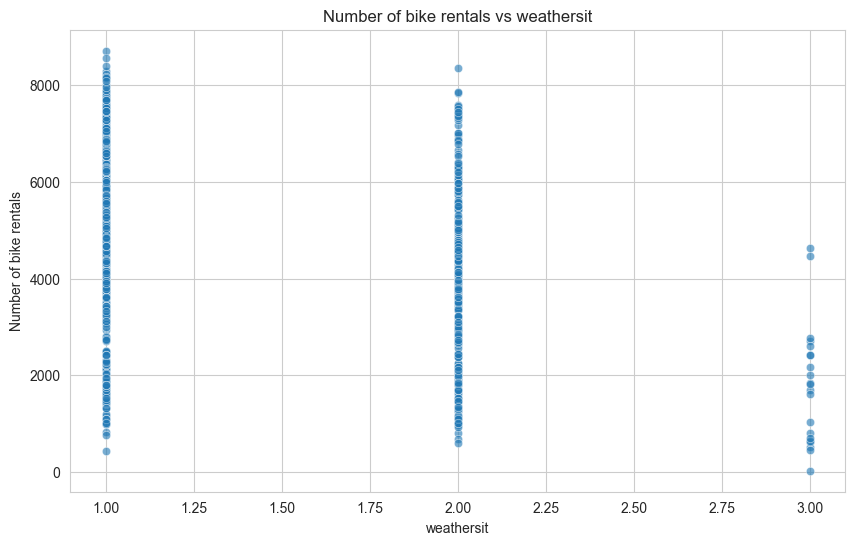

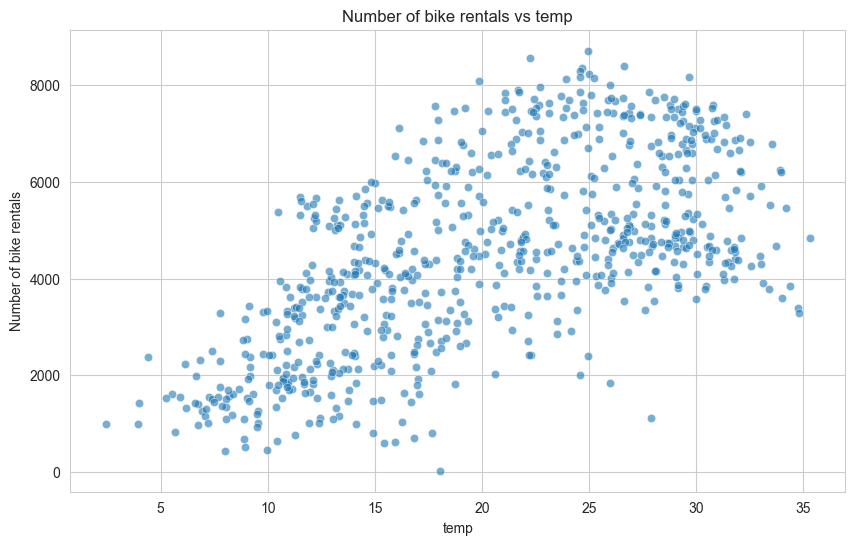

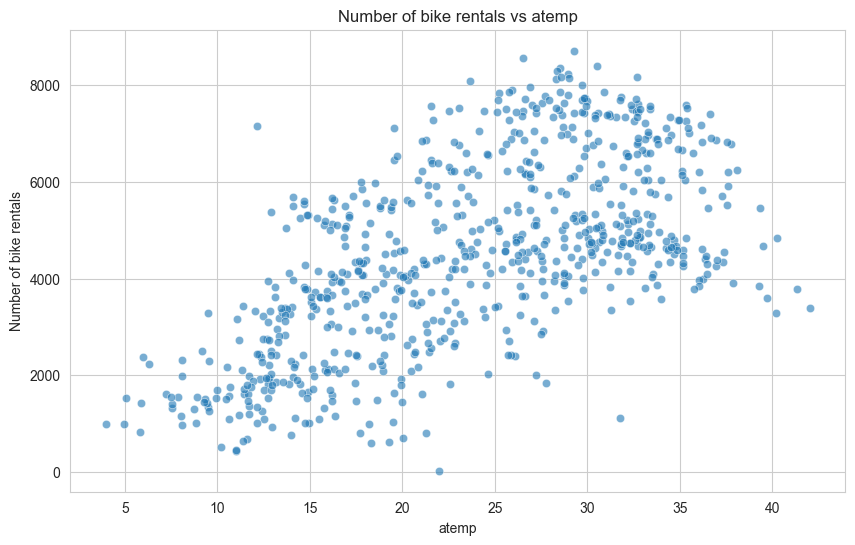

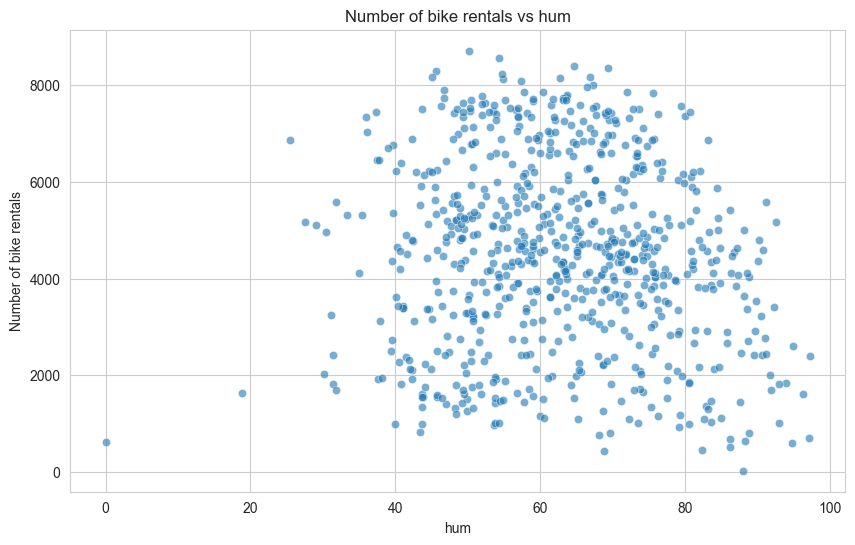

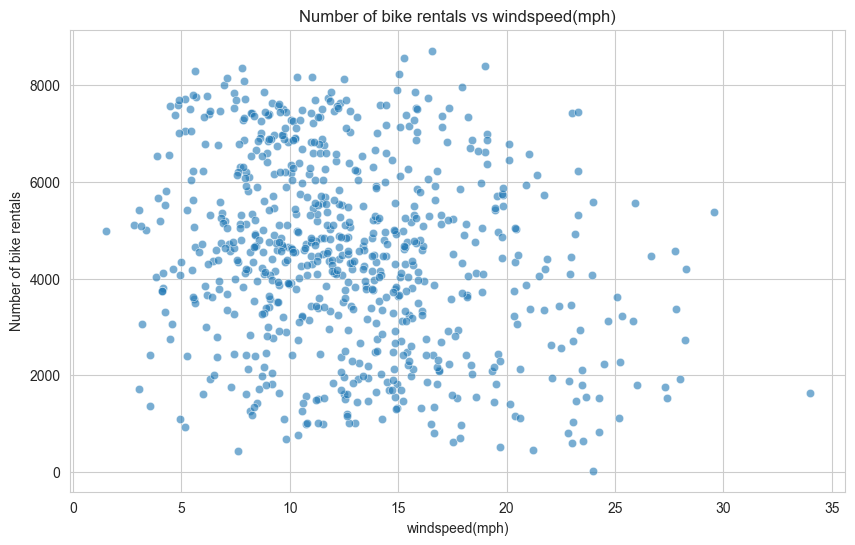

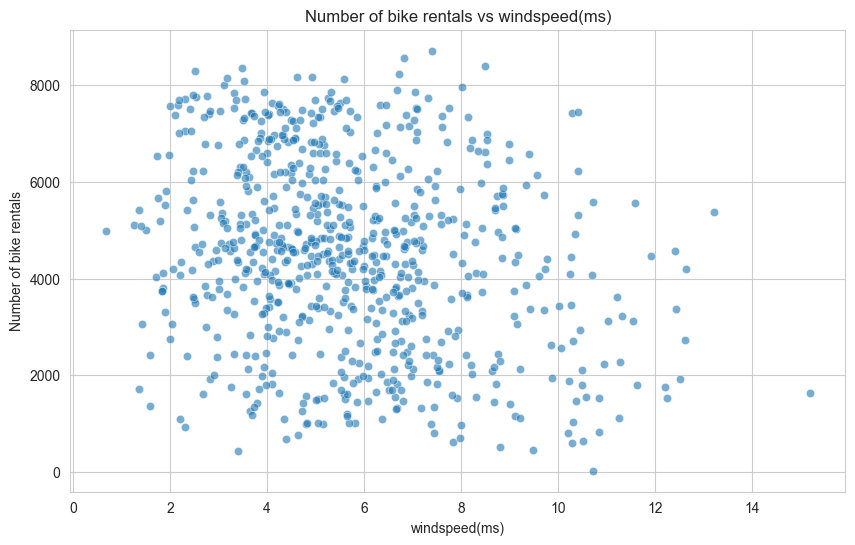

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the list of features to plot
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
            'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Plot each feature against the bike rental counts
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=feature, y='cnt', alpha=0.6)
    plt.title(f'Number of bike rentals vs {feature}')
    plt.ylabel('Number of bike rentals')
    plt.xlabel(feature)
    plt.show()

#Answer:Bike rentals usually have a seasonal pattern. In colder months, we expect fewer rentals,
# while in warmer months, rentals typically increase. Hence, the relationship would likely show higher rentals
# in the middle of the year (spring and summer) and lower at the beginning and end of the year (winter).
#Answer: Temperature (temp or atemp): The number of bike rentals is likely to have a positive linear relationship with temperature. 
# As it gets warmer, more people are likely to rent bikes.
# Year (yr): If the bike rental service is becoming more popular over time, we might see a linear increase in rentals year over year.

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [5]:
# Calculate the Pearson correlation coefficients between all features (except the last one) and the target variable 'cnt'
correlations = df.iloc[:, :-1].corrwith(df['cnt'])

# Display the correlation coefficients
correlations.sort_values(ascending=False)

atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
weathersit       -0.297391
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [7]:
# Calculate the Pearson correlation coefficients among the real-valued features and the target variable 'cnt'
selected_features = real_valued_features + ['cnt']
pairwise_correlations = df[selected_features].corr()

# Display the pairwise correlation matrix
pairwise_correlations

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [8]:
# Calculate the mean (average) values for each feature in the dataset
feature_averages = df.mean()

# Display the averages of the features
feature_averages

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [9]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [10]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [11]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [12]:
# Train the linear regression model
linear_regression_model = LinearRegression()
linear_regression_model.fit(X, y)

# Retrieve the feature names and their corresponding coefficients
feature_weights = list(zip(df_shuffled.columns[:-1], linear_regression_model.coef_))

feature_weights

[('season', 570.8638501320808),
 ('yr', 1021.968374035042),
 ('mnth', -141.30042714888475),
 ('holiday', -86.7589678764022),
 ('weekday', 137.2260243674752),
 ('workingday', 56.39207450989123),
 ('weathersit', -330.22859154239825),
 ('temp', 367.45187644001305),
 ('atemp', 585.5777455406493),
 ('hum', -145.61314651687744),
 ('windspeed(mph)', 12456475364833.373),
 ('windspeed(ms)', -12456475365031.836)]

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [13]:
from sklearn.linear_model import Lasso

# Train the Lasso regression model with default parameters
lasso_regression_model = Lasso()
lasso_regression_model.fit(X, y)

# Retrieve the feature names and their corresponding coefficients for Lasso regression
lasso_feature_weights = list(zip(df_shuffled.columns[:-1], lasso_regression_model.coef_))

lasso_feature_weights

[('season', 560.2416160308862),
 ('yr', 1019.4634940657196),
 ('mnth', -128.7306270367869),
 ('holiday', -86.15278133371095),
 ('weekday', 137.3478939049631),
 ('workingday', 55.21237064135677),
 ('weathersit', -332.3698569623486),
 ('temp', 376.36323620969597),
 ('atemp', 576.5307935045538),
 ('hum', -144.129155003486),
 ('windspeed(mph)', -197.13968940248404),
 ('windspeed(ms)', -2.8051512738133662e-08)]

Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [14]:
from sklearn.linear_model import Ridge

# Train the Ridge regression model with default parameters
ridge_regression_model = Ridge()
ridge_regression_model.fit(X, y)

# Retrieve the feature names and their corresponding coefficients for Ridge regression
ridge_feature_weights = list(zip(df_shuffled.columns[:-1], ridge_regression_model.coef_))

ridge_feature_weights


[('season', 563.0645722520193),
 ('yr', 1018.9483787875306),
 ('mnth', -131.8733202824786),
 ('holiday', -86.74609799709202),
 ('weekday', 138.00511117871915),
 ('workingday', 55.903110375064806),
 ('weathersit', -332.3497884990724),
 ('temp', 386.4578891919171),
 ('atemp', 566.3470470600581),
 ('hum', -145.07132729867268),
 ('windspeed(mph)', -99.25944108181756),
 ('windspeed(ms)', -99.25944115431525)]

### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [15]:
# Define the range of alpha values
alphas = np.arange(1, 500, 50)

# Initialize lists to store the weights
coefs_lasso = []
coefs_ridge = []

# Train Lasso and Ridge regressors for each alpha and store the coefficients
for alpha in alphas:
    # Lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Convert lists to numpy arrays
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Display shapes of the arrays to confirm
coefs_lasso.shape, coefs_ridge.shape

((10, 12), (10, 12))

Проанализируйте динамику весов при увеличении параметра регуляризации:

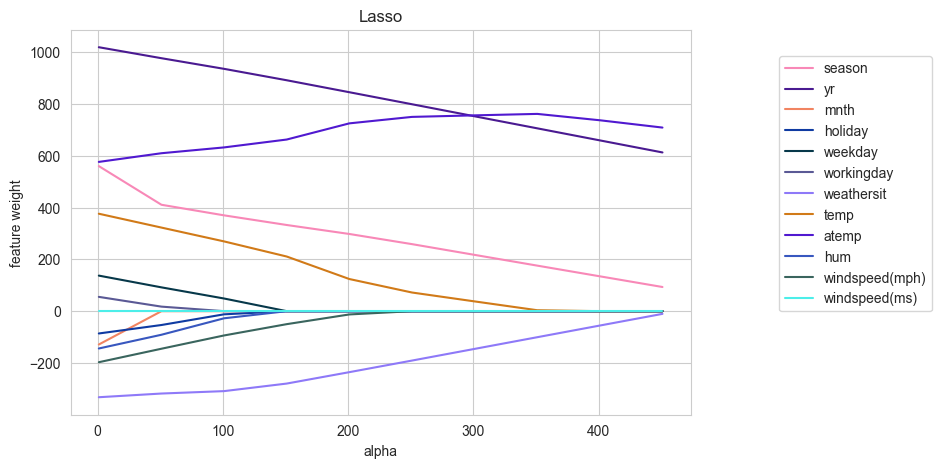

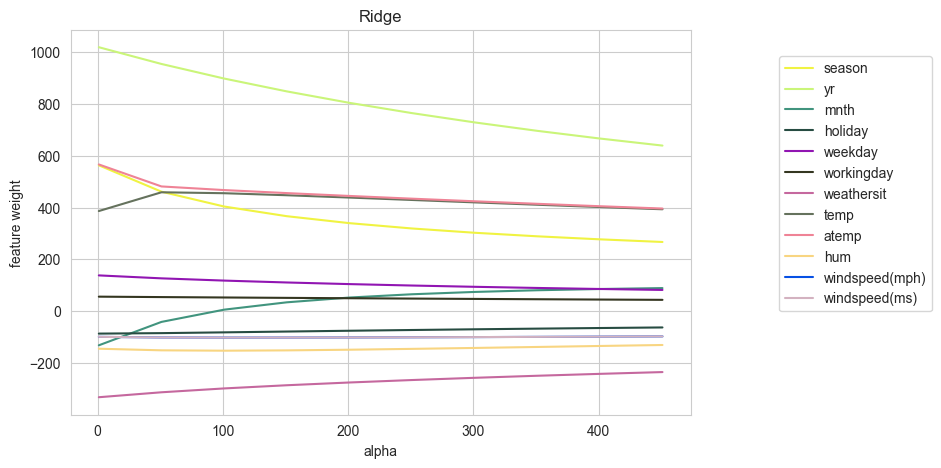

In [16]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

In [19]:
### Observations and Answers to Questions

1. Which regularizer reduces weights more aggressively for the same alpha?
   Lasso regularization tends to reduce the weights more aggressively as the regularization strength (`alpha`) increases, often setting several of them to zero.

2. What happens to the Lasso scales if alpha is made very large?
   As `alpha` becomes very large, Lasso regularization drives most feature weights to zero, effectively excluding them from the model.
   This occurs because Lasso can impose a sparsity constraint, which simplifies the model by selecting only the most important features.

3. Can we say that Lasso excludes one of the windspeed features for any value of alpha > 0? And Ridge?  
   With Lasso regularization, one of the windspeed features is indeed excluded (its weight is reduced to zero) for any `alpha` > 0. 
   This is a characteristic behavior of Lasso, which is used for feature selection. Ridge regularization,
   however, does not set the weights to zero but merely shrinks them.

4. Which regularizer is suitable for selecting uninformative features?  
   Lasso regularization is more suitable for selecting uninformative features because it can completely eliminate their weights,
   while Ridge regularization will retain all features with non-zero weights regardless of the `alpha` value.


IndentationError: unexpected indent (1082737774.py, line 4)

## Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [22]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

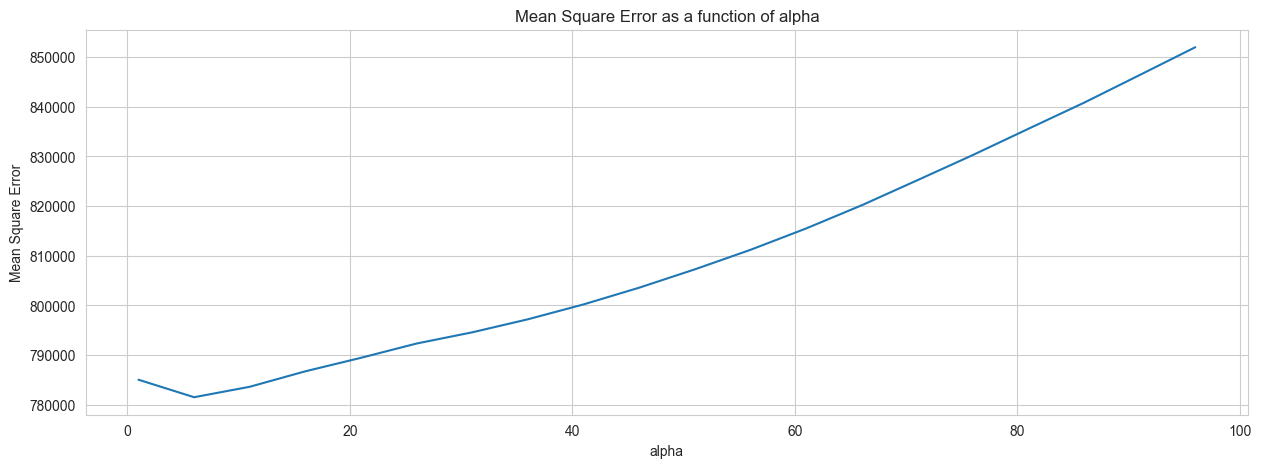

Selected alpha: 6
Feature-coefficient pairs:
season: 532.0189828413536
yr: 1015.0602226430597
mnth: -100.03952614356652
holiday: -83.2939598752991
weekday: 132.50446549095793
workingday: 51.557085614074055
weathersit: -330.5598567399815
temp: 370.67985503003166
atemp: 581.3969310655002
hum: -140.00740550068855
windspeed(mph): -191.7714084713498
windspeed(ms): -2.6855326892515688e-08


In [25]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3, random_state=42)

# Fit the regressor to the data
regressor.fit(X, y)

# Create a plot of the mean square errors
mse_mean = regressor.mse_path_.mean(axis=1)
alphas = regressor.alphas_

# Define the plotting function
def create_plot(x, y, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Use the plotting function to create the plot
create_plot(alphas, mse_mean, "Mean Square Error as a function of alpha", "alpha", "Mean Square Error")

# Print the selected alpha
print(f"Selected alpha: {regressor.alpha_}")

# Print the feature-coefficient pairs
feature_weights_lasso_cv = list(zip(df_shuffled.columns[:-1], regressor.coef_))
print("Feature-coefficient pairs:")
for feature, weight in feature_weights_lasso_cv:
    print(f"{feature}: {weight}")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Fold 1: Alpha = 6, MSE = 733725.760405224
Fold 2: Alpha = 1, MSE = 799433.1673691698
Fold 3: Alpha = 51, MSE = 796979.8955193625

Best average alpha: 6


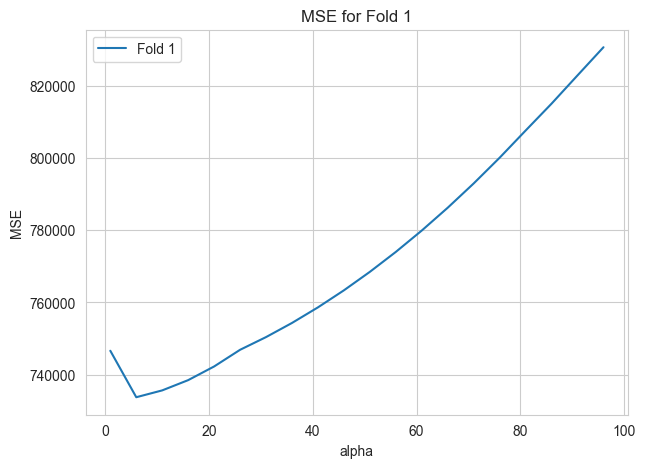

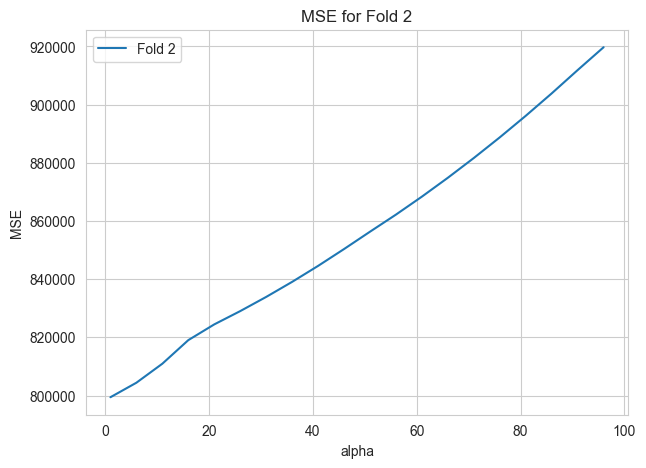

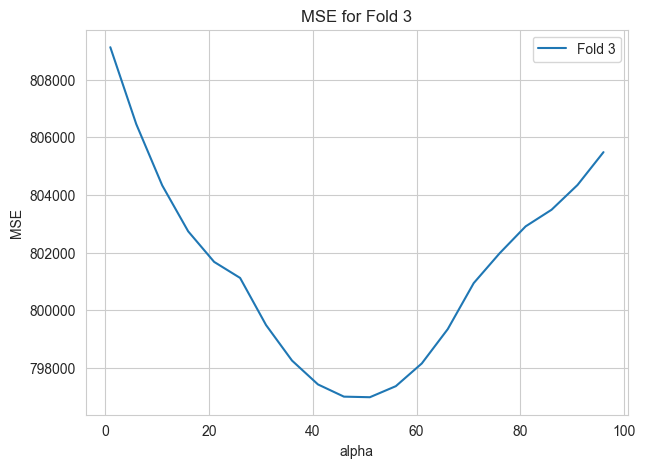

In [29]:
# Extract the minimum MSE and corresponding alpha for each fold
mse_path = regressor.mse_path_
alphas_optimal = regressor.alphas_[np.argmin(mse_path, axis=0)]
min_mse_each_fold = np.min(mse_path, axis=0)

# Display the alpha with the minimum MSE for each fold
for fold in range(mse_path.shape[1]):
    print(f"Fold {fold+1}: Alpha = {alphas_optimal[fold]}, MSE = {min_mse_each_fold[fold]}")

# Calculate and display the alpha that has the best average performance across all folds
average_best_alpha = regressor.alphas_[np.argmin(np.mean(mse_path, axis=1))]
print(f"\nBest average alpha: {average_best_alpha}")

# Plotting the MSE for each fold
for fold in range(mse_path.shape[1]):
    plt.figure(figsize=(7, 5))
    plt.plot(regressor.alphas_, mse_path[:, fold], label=f'Fold {fold+1}')
    plt.title(f'MSE for Fold {fold+1}')
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [11]:
# The top features with positive coefficients—yr, atemp, season, and temp—suggest more bike rentals as values increase.
# This aligns with expectations: rentals likely grow over years (yr), and more people rent bikes in warmer conditions (atemp, temp)
# and favorable seasons. The data visualization should corroborate this trend, confirming the logical assumption that pleasant weather
# and temporal factors boost bike rental frequency.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [12]:
# The features with the largest negative coefficients—weathersit, hum, and windspeed(mph)—all indicate adverse weather conditions. 
# Higher weathersit values mean poor weather, increased hum suggests uncomfortable levels of humidity, and greater windspeed(mph) indicates stronger
# winds. Such conditions are typically unfavorable for cycling, logically leading to fewer bike rentals. The expected visualizations would show 
# a decline in bike rentals as these environmental factors worsen, confirming the intuitive inverse relationship.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [13]:
# In the Lasso model, the feature windspeed(ms) has a coefficient close to zero, likely due to its redundancy with windspeed(mph)—both 
# represent wind speed but in different units. Lasso excludes it to prevent multicollinearity. While the graph for windspeed(ms) shows
# diminishing importance as alpha increases, this does not imply it has no effect on bicycle demand. Instead, its predictive power is captured 
# by other correlated features, and excluding it simplifies the model without sacrificing performance.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.